<strong>Aluno</strong>: Victor São Paulo Ruela



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [26]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.01, max_epochs=100):
        self.eta = eta
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return np.sign(u)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        n_epochs = 0

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)

            for i_rand in xseq:
                yhati = 1.0 * ((x_aug[i_rand, :] @ wt) >= 0)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw
            # increment number of epochs
            n_epochs = n_epochs + 1

        return wt

# Implementação do perceptron simples para um problema de classificação binário
class ELM:
    def __init__(self, p=5):
        self.p = p

    def predict(self, x, w, H, Z):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        H = np.tanh(x_aug @ Z)
        u = np.sign(H @ w)
        return u

    def train(self, x_train, y_train):
        N, n = x_train.shape
        # augment X
        x_aug = np.hstack((-np.ones((N, 1)), x_train))
        # create initial Z matrix
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))
        # apply activation function: tanh
        H = np.tanh(x_aug @ Z)
        # calculate the weights
        w = np.linalg.pinv(H) @ y_train
        return w, H, Z

In [27]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [28]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [55]:
# split the data
def train_test_split(X, y, ratio=0.7):
    N = len(y)
    x_rand = np.arange(N)
    np.random.shuffle(x_rand)
    i_split = int(np.floor(ratio * N))

    x_train, x_test = x_rand[:i_split], x_rand[i_split:]
    return X[x_train,:], y[x_train], X[x_test,:], y[x_test]


def perceptron_experiment(X, y, N=5, print_results=True):
    # split the data
    X_train, y_train, X_test, y_test= train_test_split(X, y)
    model = LinearPerceptron(max_epochs=100)
    accuracy_results = []
    for i in range(N):
        # train the model on training set
        w = model.train(X_train, y_train)
        # make predictions for the teste set
        yhat = model.predict(X_test, w)
        # accuracy
        accuracy = 100 * np.sum(y_test == yhat)/len(yhat)
        accuracy_results.append(accuracy)
        
    if(print_results == True):
        plt.plot(accuracy_results, 'ko-')
        plt.xlabel('Iteração')
        plt.ylabel('Acurácia (%)')
        print(f'Média: {np.mean(accuracy_results)}')
        print(f'Desvio padrão: {np.std(accuracy_results)}')

def elm_experiment(X, y, p=10, N=5, print_results=True):
    # split the data
    X_train, y_train, X_test, y_test= train_test_split(X, y)
    model = ELM(p=p)
    accuracy_results = []
    accuracy_results_train = []
    for i in range(N):
        # train the model on training set
        w, H, Z = model.train(X_train, y_train)
        # make predictions for the teste set
        yhat = model.predict(X_test, w, H, Z)
        # accuracy
        accuracy = 100 * np.sum(y_test == yhat)/len(yhat)
        accuracy_results.append(accuracy)
        yhat_train = model.predict(X_train, w, H, Z)
        accuracy_results_train.append(100 * np.sum(y_train == yhat_train)/len(yhat_train))
        
    if(print_results == True):
        plt.plot(accuracy_results, 'ko-')
        plt.xlabel('Iteração')
        plt.ylabel('Acurácia (%)')
        print(f'Média: {np.mean(accuracy_results)}')
        print(f'Desvio padrão: {np.std(accuracy_results)}')

    return accuracy_results, accuracy_results_train

def elm_experiment_complete(X, y, N=10, neurons=[5,15,30,50]):
    experiment_values = {}
    experiment_values_train = {}
    for p in neurons:
        experiment_values[p], experiment_values_train[p] = elm_experiment(X,y,p,N,False)

    return experiment_values, experiment_values_train

<AxesSubplot:xlabel='Neurônios', ylabel='Acurácia'>

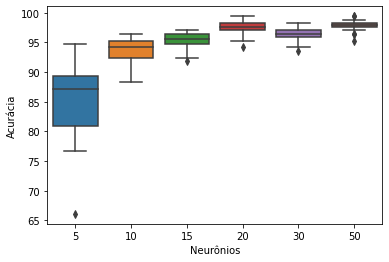

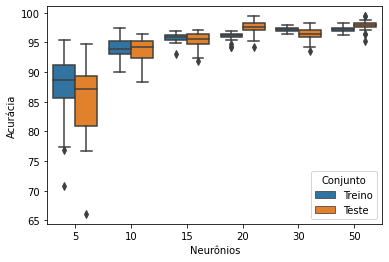

In [59]:
neurons=[5,10,15,20,30,50]
res_test, res_train = elm_experiment_complete(X_bc,y_bc, neurons=neurons, N=30)
res_test_df = pd.DataFrame().from_dict(res_test).melt(value_vars=neurons, value_name='Acurácia', var_name='Neurônios')
res_train_df = pd.DataFrame().from_dict(res_train).melt(value_vars=neurons, value_name='Acurácia', var_name='Neurônios')

res_train_df['Conjunto'] = 'Treino'
res_test_df['Conjunto'] = 'Teste'

res_complete = pd.concat([res_train_df, res_test_df], ignore_index=True)

plt.figure()
sns.boxplot(data=res_test_df, x='Neurônios',y='Acurácia')

#sns.boxplot(data=res_train_df, x='Neurônios',y='Acurácia')
plt.figure()
sns.boxplot(data=res_complete, x='Neurônios',y='Acurácia',hue='Conjunto')


<AxesSubplot:xlabel='Neurônios', ylabel='Acurácia'>

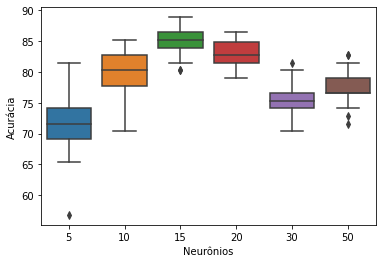

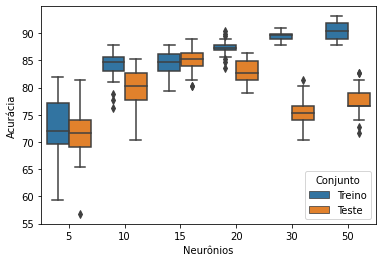

In [60]:
neurons=[5,10,15,20,30,50]
res_test, res_train = elm_experiment_complete(X_hd, y_hd, neurons=neurons, N=30)
res_test_df = pd.DataFrame().from_dict(res_test).melt(value_vars=neurons, value_name='Acurácia', var_name='Neurônios')
res_train_df = pd.DataFrame().from_dict(res_train).melt(value_vars=neurons, value_name='Acurácia', var_name='Neurônios')

res_train_df['Conjunto'] = 'Treino'
res_test_df['Conjunto'] = 'Teste'

res_complete = pd.concat([res_train_df, res_test_df], ignore_index=True)

plt.figure()
sns.boxplot(data=res_test_df, x='Neurônios',y='Acurácia')

#sns.boxplot(data=res_train_df, x='Neurônios',y='Acurácia')
plt.figure()
sns.boxplot(data=res_complete, x='Neurônios',y='Acurácia',hue='Conjunto')


Média: 53.21637426900585
Desvio padrão: 0.0


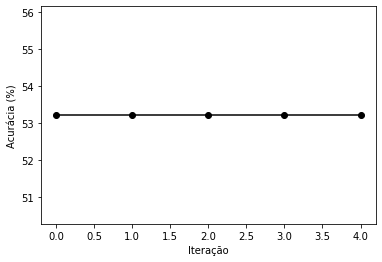

In [30]:
perceptron_experiment(X_bc, y_bc)
elm_experiment(X_bc, y_bc)

Média: 54.320987654320994
Desvio padrão: 7.105427357601002e-15
Média: 79.25925925925927
Desvio padrão: 2.393915978971024


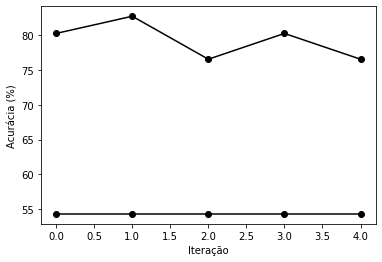

In [32]:
perceptron_experiment(X_hd, y_hd)
elm_experiment(X_hd, y_hd)